# Analysis of coffee shops distributions in major Scandinavian cities

## 1. Introduction 

As we can see from the CBI report (see below) speciality coffee is a growing niche market making it an interesting business opportunity.

From CBI (Centre for the Promotion of Imports from developing countries):
> Europe is a large market for coffee. Opportunities for small and medium-sized suppliers from producing countries are best found in the growing specialty coffee market in Europe. Although still a niche market, there is a growing demand for high-quality and single origin coffees.
[Read more here](https://www.cbi.eu/market-information/coffee/trade-statistics/#the-european-market-for-specialty-coffee-is-growing)

From Wikipedia:
>Europe is already a major coffee market accounting for 30% of global consumption, but is seeing a growth in demand for specialty coffee while overall demand remains stable. In 2016, specialty coffee was Europe’s fastest growing major restaurant category, with an increase of 9.1% from 2014-2015.

## Business Problem
Speciality coffee is also referred as third-wave coffee to distinguish of the second-wave coffee characterised by coffee-shops franchises.
This coffee-shops are usually smaller than their franchise counterparts and have to play smartly to gain market-share. Since this a new trend consumers might not be aware of the differences and remain within the traditional coffee-shops. 
In order to attract new costumers and be able to differentiate from traditional coffee-shops, speciality cafes needs to be able to create communities and define a new coffee culture. In this matter, geographic location can play a major role. The relative distance between speciality and traditional coffee shops can help create synergies among small cafes and mitigate the effects of more aggressive players like franchises. 

### Finally, the problem we are trying to solve is to identify potencial places where a new speciality coffee-shop will florish.

## Data


### 1. Speciality cafes names and place: Web Scrapping
In order to solve this problem we can gather already successful speciality coffee shops from different cities of Europe. We can get a list of them per city from the website: European Coffee Trip (https://europeancoffeetrip.com/). For example this a list for Stockholm: https://europeancoffeetrip.com/stockholm/ 

For web scraping we are using BeautifulSoup and CSS selectors

In [ ]:
import requests # library to handle requests
from bs4 import BeautifulSoup # library to scrape using css selectors
from collections import defaultdict 

### Scrapping a single place

First we are going to collect the names of speciality coffee shops from https://europeancoffeetrip.com/. We start by printing the names of the coffee shops to check if out CSS selector is working.

In [ ]:
url = 'https://europeancoffeetrip.com/stockholm/'
cafes_text = requests.get(url).text
cafes_soup = BeautifulSoup(markup=cafes_text, features='html.parser')

In [ ]:
cafes_names = [title.text for title in cafes_soup.select('#first-cafes .cg-list-single-title')]
print(cafes_names)

### Scrapping all the places
In order to extract the names of the coffee shops in all the availables countries, we first need to get the URL of each country. With those URLs then we can extract their respectives coffee places.

In [ ]:
url = 'https://europeancoffeetrip.com/city-guides/'
guides_text = requests.get(url).text
guides_soup = BeautifulSoup(markup=guides_text, features='html.parser')

In [ ]:
# Extracting the countries URLs
countries_url = [country['href'] for country in guides_soup.select('.cg-single-item > div > a')]
print(countries_url)

In [ ]:
cafes_dict = defaultdict(list)
for country_url in countries_url:
    cafes_text = requests.get(country_url).text
    cafes_soup = BeautifulSoup(markup=cafes_text, features='html.parser')
    cafes = cafes_soup.select('[id$="-cafes"].cg-list > a[href*="/cafe/"]')
    for cafe in cafes:
        cafes_dict[cafe.span.text].append(cafe.h3.text)

We can save the dictionary as a JSON file so we don't request again the same information to the site

In [ ]:
from json import dump
with open('cafes.json', 'w') as jsonfile:
    dump(cafes_dict, jsonfile, indent=4)

We can load the JSON now

In [ ]:
from json import load
with open('cafes.json') as cafes_file:
    speciality_cafes = load(cafes_file)

In [ ]:
speciality_cafes['Oslo']

### 2. Name of coffehouse chains 
According to:
* https://en.wikipedia.org/wiki/List_of_coffeehouse_chains
* http://www.europeancoffeesymposium.com/nordic-coffee-culture-up-and-up/

This are the most common cafe chains in the nordic countries.
> 'Espresso House', 'Waynes Coffee', 'Starbucks', 'JOE & THE JUICE'

We just need a python list with the names that we can later use to find their different locations.

In [ ]:
chains_cafes = ['Espresso House', 'Waynes Coffee', 'Starbucks', 'JOE & THE JUICE']

### 3.Foursquare API
With a list of names for speciality and chains cafes we can use the Foursquare API to check for their geographical location.  We are going to focus only on this cities:


In [255]:
cities = ['Stockholm', 'Gothenburg','Malmö','Copenhagen','Oslo']

In [256]:
import requests
from enum import Enum
from urllib.parse import quote
import pandas as pd
from geopy.geocoders import Nominatim
import config

#### Kinds of coffeeshops
We are going to divide the cafes into 3 categories.
For that we are going to use an enum named Cafe containing: Speciality, Chain and Other.

In [ ]:
class Cafe(Enum):
    SPECIALITY = 1
    CHAIN = 2
    OTHER = 3

### Finding all the cafes in a city

We are using the "Search" API to find the location of the speciality cafes we scrapped from "European Coffe Trip" website. The results will be tagged using the enum `Cafe.SPECIALITY`.
With this same API we make a general search to get all the cofehouse chains in the area and tag those results with `Cafe.CHAINS`. Finally, we use their "Explore" API to find all the other cafes in the area and tag them as `Cafe.OTHER`. 

This is how the information can be gathered in a dataset containing the cafes names, location, city, country and type.

We are going to need two functions:
* `explore_coffe`: can give us back a DataFrame containg all the cafes found in a city regardless of their kind, so we will asume their kind is Other
* `find_coffee`: can give us back a DataFrame containg the info of a specific coffeshop and we can tag them as Speciality or Chain 

In [ ]:
def explore_coffee(in_city:str) -> pd.DataFrame:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(in_city)
    radius = 3000
    url = f'https://api.foursquare.com/v2/venues/explore?client_id={config.foursquare_clientid}&client_secret={config.foursquare_clientsecret}&ll={location.latitude},{location.longitude}&v=20200304&section=coffee&&radius={radius}&time=any&day=any'
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    if len(items) == 0:
        return None
    filtered_columns = ['venue.name', 'venue.location.lat', 'venue.location.lng', 'venue.location.city','venue.location.country']
    df_result = pd.json_normalize(items).set_index('venue.id').loc[:,filtered_columns]
    df_result.index.name = 'id'
    df_result.columns = [column.split('.')[-1] for column in df_result]
    df_result['type'] = Cafe.OTHER
    return df_result
    

def find_coffee(name:str, in_city:str, cafe_type=Cafe.CHAIN, number: int=50) -> pd.DataFrame:
    print(f'{name}')
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(in_city)
    radius = 3000
    url = f'https://api.foursquare.com/v2/venues/search?client_id={config.foursquare_clientid}&client_secret={config.foursquare_clientsecret}&ll={location.latitude},{location.longitude}&v=20200304&query={quote(name)}&limit={number}&radius={radius}'
    results = requests.get(url).json()
    filter_result = [cafe for cafe in results['response']['venues'] if name.lower() in cafe['name'].lower()]
    print(f'Found {len(filter_result)} coffees')
    if len(filter_result) == 0:
        return None
    try:
        filtered_columns = ['name', 'location.lat', 'location.lng', 'location.city','location.country']
        df_result = pd.json_normalize(filter_result).set_index('id').loc[:,filtered_columns]
    except:
        print(filter_result)
        return None
    df_result.columns = [column.split('.')[-1] for column in df_result]
    df_result['type'] = cafe_type
    return df_result

We can try this function two functions with an Example

In [ ]:
df_explore = explore_coffee('Stockholm')
df_explore.head()

In [ ]:
df_coffe = find_coffee('Espresso House', 'Stockholm')

Now for each city we can search for the specility cafes first, then the chains and finally all the rest. We can store the DataFrames returned by the previous functions into a single array. This will help later to create a single DataFrame where we remove duplicates and keep just the first copies, that are actually the properly tagged ones.

In [ ]:
list_of_df = []
for city in cities:
    print(f'In {city}: ....')
    for coffee_name in speciality_cafes[city]:
        df_cafe = find_coffee(coffee_name, city, cafe_type=Cafe.SPECIALITY, number=1)
        list_of_df.append(df_cafe)
    for coffee_name in chains_cafes:
        df_cafe = find_coffee(coffee_name, city, cafe_type=Cafe.CHAIN)
        list_of_df.append(df_cafe)
    df_cafe = explore_coffee(in_city=city)
    list_of_df.append(df_cafe)

We can use Pandas `concat` function to merge all the Dataframes in our previous list into a single DataFrame and at the same time remove the duplicates

In [ ]:
scandinavian_cafes = pd.concat(list_of_df).drop_duplicates(keep='first')
scandinavian_cafes = scandinavian_cafes.loc[~scandinavian_cafes.index.duplicated(keep='first')]
scandinavian_cafes.describe(include='all')

There is still some cleaning needed. Some cafes don't contain the city name and some are located in other cities.

In [ ]:
index_to_remove = []
index_to_remove.extend(scandinavian_cafes.loc[ (scandinavian_cafes['country'] == 'Norge') & (scandinavian_cafes['city'].isna()) ].index)
index_to_remove.extend(scandinavian_cafes.loc[ (scandinavian_cafes['country'] == 'Sverige') & (scandinavian_cafes['city'].isna()) ].index)
index_to_remove.extend(scandinavian_cafes.loc[ scandinavian_cafes['city'] == 'Johanneshov' ].index)
index_to_remove.extend(scandinavian_cafes.loc[ scandinavian_cafes['city'] == 'Bö, Göteborg' ].index)
index_to_remove.extend(scandinavian_cafes.loc[ scandinavian_cafes['city'] == 'Bö' ].index)
index_to_remove.extend(scandinavian_cafes.loc[ scandinavian_cafes['city'] == 'Malmö stad' ].index)
scandinavian_cafes.drop(index=index_to_remove, inplace=True)

We are going to rename some of the cities to their english names and simplify the naming.

In [ ]:
rename_dict = {'Göteborg': 'Gothenburg',
        np.nan: 'Copenhagen',
       'København': 'Copenhagen',
       'København K': 'Copenhagen',
       'København Ø': 'Copenhagen',
       'København V': 'Copenhagen',
       'Frederiksberg': 'Copenhagen',
       'København S': 'Copenhagen',
       'Copenhagen V': 'Copenhagen',
       'København SV': 'Copenhagen',
       'København N': 'Copenhagen',
       'Copenhagen K': 'Copenhagen',
       'Sentrum': 'Oslo'}
scandinavian_cafes.replace(to_replace=rename_dict, inplace=True)

In [ ]:
scandinavian_cafes.describe(include='all')

At this point we have a clean dataset that we can use for our analysis. So we can store it in this way:

In [ ]:
scandinavian_cafes.to_pickle('./scandinavian_cafes.pkl')

To load the previous dataset we can use this:

In [298]:
scandinavian_cafes = pd.read_pickle("./scandinavian_cafes.pkl")
scandinavian_cafes.head()

,name,lat,lng,city,country,type
id,,,,,,
4b2c9ad1f964a52016c824e3,Kaffeverket,59.341349,18.038021,Stockholm,Sverige,Cafe.SPECIALITY
5ba7325e1ffed7002c8063be,Guld Kaffe & Kök,59.339917,18.045181,Stockholm,Sverige,Cafe.SPECIALITY
59a910f8acb00b097b7434a5,Gast,59.339818,18.056633,Stockholm,Sverige,Cafe.SPECIALITY
4af290f1f964a520efe721e3,Drop Coffee,59.316910,18.063004,Stockholm,Sverige,Cafe.SPECIALITY
5aad22a00e5da802a686cf1b,Café Pascal,59.312227,18.078946,Stockholm,Sverige,Cafe.SPECIALITY


## 3.Methodology
### 3.1.Visualizing in the map
We can use folium to visualize with markers of different colors how this three clases of cafes distributes on each city.

In [297]:
import folium
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'lightgray', 'black']

We are going to make a dictionary for the colors of each kind of coffee
* lightblue: speciality shops
* lightgreen: chains
* lightred: others

In [260]:
cafe_icon = dict(zip([i for i in Cafe], ['lightblue', 'lightgreen', 'lightred']))

We can make a function to plot the map of a city

In [262]:
def city_cafes_map(city: str) -> folium.Map:
    # Create the map
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(city)
    city_map = folium.Map(location=[location.latitude, location.longitude], zoom_start=14, tiles='Stamen Toner')
    if city not in scandinavian_cafes['city'].unique():
        return city_map
    cafes = scandinavian_cafes.loc[scandinavian_cafes['city']==city, ['name', 'lat', 'lng', 'type']]
    # add markers to the map
    for _, cafe in cafes.iterrows():
        label_str = cafe['name']
        label = folium.Popup(label_str, parse_html=True)
        icon = folium.Icon(color=cafe_icon[cafe['type']])
        folium.Marker(
            location=[cafe['lat'], cafe['lng']],
            popup=label,
            tooltip=cafe['name'],
            icon=icon).add_to(city_map)

    return city_map

In [263]:
city_cafes_map('Gothenburg')

In [264]:
city_cafes_map('Stockholm')

In [265]:
city_cafes_map('Oslo')

In [266]:
city_cafes_map('Copenhagen')

In [267]:
city_cafes_map('Malmö')

We can see how the chains cafes seems to organize in clusters whereas the speciality cafes position in general outside the more dense areas.

### 3.2 Analyzing the data with K-Means
We can start by using K-Means to identify the clusters. Because K-Means trys to get an even cluster size we can see what are the differences in the composition of each cluster. 
* Are all the clusters equally distributed? 
* or are there clusters with bigger percentage of one kind of cafe?

In [299]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.2.1


We are going to start with one city: Stockholm

In [269]:
city = 'Stockholm'
cafes_in_city = scandinavian_cafes.loc[scandinavian_cafes['city']==city, ['lat', 'lng']].reset_index(drop=True)

This clustering will work better if the data is normalize. We will use the standard scaler from scikit

In [270]:
scaler = StandardScaler().fit(cafes_in_city)
cafes_in_city = scaler.transform(cafes_in_city)

K-Means requieres that we define the number of clusters.

To select the number of cluster we can use two metrics:
* Distorsion: within-cluster sum-of-squares. The distances from the cluster-center to its elements.
* Silhouette coefficients: near +1 indicates that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. Basically how well separated are the cluster from each other

We want a number of clusters that give us:
* a low distorsion, that's to say elements of the cluser are close to each other 
* and a big average silhouette, in other words, elements of the border of the cluster are far from the border elements of the neighbor cluster.

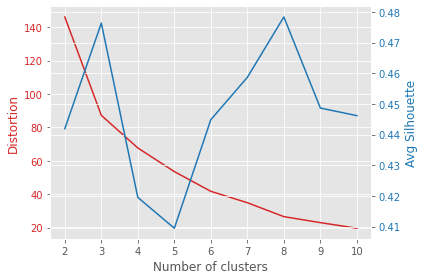

In [271]:
distortions = []
centers = []
silhouettes = []
for i in range(2, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(cafes_in_city)
    centers.append(km.cluster_centers_)
    distortions.append(km.inertia_)
    predict = km.predict(cafes_in_city)
    silhouettes_avg = silhouette_score(cafes_in_city, predict)
    silhouettes.append(silhouettes_avg)

# plot
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Distortion', color=color)
ax1.plot(range(2,11), distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Avg Silhouette', color=color)  # we already handled the x-label with ax1
ax2.plot(range(2,11), silhouettes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

We can see that with 8 cluster we have a low distortion and big average silhouette 

In [272]:
# We are going to use k=8
k = 8
km = KMeans(
        n_clusters=k, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
km_labels = km.fit_predict(cafes_in_city)

In [273]:
cafes = scandinavian_cafes.loc[scandinavian_cafes['city']==city, ['name', 'lat', 'lng', 'type']]
cafes['km_label'] = km_labels

In [274]:
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(city)
city_map = folium.Map(location=[location.latitude, location.longitude], zoom_start=14, tiles='Stamen Toner')

# add markers to the map
for _, cafe in cafes.iterrows():
    label_str = cafe['name']
    label = folium.Popup(label_str, parse_html=True)
    icon = folium.Icon(color=colors[cafe['km_label']])
    folium.Marker(
        location=[cafe['lat'], cafe['lng']],
        popup=label,
        tooltip=f"Cluster {cafe['km_label']}: {cafe['name']}",
        icon=icon).add_to(city_map)
city_map

Now we can use the cluster labels to group the data and sum for each kind of cafe

In [275]:
cafes['type_values'] = [e.name for e in cafes['type']]
cafes_onehot = pd.get_dummies(cafes['type_values'])
cafes_onehot['km_labels'] = km_labels
cafes_group = cafes_onehot.groupby(['km_labels']).sum()

We can visualize using a bar chart to understad how the different kind of cafes are distributed in each cluster

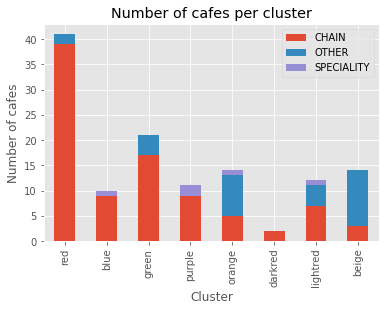

In [276]:
cafes_group.plot(kind='bar', stacked=True)
plt.xticks([i for i in range(k)], colors[:k])
plt.title('Number of cafes per cluster')
plt.ylabel('Number of cafes')
plt.xlabel('Cluster')
plt.show()

We can see how clusters with a big number of cafes from chains have a low presence of speciality and other cafes.

### 3.3 Analyzing the data with OPTICS
We can try other clustering algorithm like: OPTICS (Ordering Points To Identify the Clustering Structure) which is closely related to Density-Based Spatial Clustering. 

1. The DBSCAN algorithm views clusters as areas of high density separated by areas of low density.
2. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density.
3. Any sample that is not a core sample, and is at least epsilon in distance from any core sample, is considered an outlier by the algorithm.

This can help us understand how densily packed are the clusters and where speciality cafes position themselves respectively to the areas of high density:
* Are speciality cafes part of the core sample of the any cluster?
* or they locate in the perifery and are considered outliers by the algorithm? 

In [277]:
from sklearn.cluster import OPTICS
import numpy as np
from geopy.distance import distance

As the metric we are going to use the geodesic distance between the coffeshops

In [278]:
cafes_in_city = scandinavian_cafes.loc[scandinavian_cafes['city']==city, ['lat', 'lng']].reset_index(drop=True)
op = OPTICS(cluster_method='xi', metric=lambda u,v: distance(u,v).m ).fit(cafes_in_city)
cafes = scandinavian_cafes.loc[scandinavian_cafes['city']==city, ['name', 'lat', 'lng', 'type']]
cafes['op_label'] = op.labels_

The cluster in this algorithm are define by zones of big density of cafes and any cafe that is not close enough to a cluster will be considered an outlier.
In this map, the markers in black represents outliers: cafes that are not part of a cluster.

In [279]:
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(city)
city_map = folium.Map(location=[location.latitude, location.longitude], zoom_start=14, tiles='Stamen Toner')
# add markers to the map
for _, cafe in cafes.iterrows():
    label_str = cafe['name']
    label = folium.Popup(label_str, parse_html=True)
    icon = folium.Icon(color=colors[cafe['op_label']])
    folium.Marker(
        location=[cafe['lat'], cafe['lng']],
        popup=label,
        tooltip=cafe['name'],
        icon=icon).add_to(city_map)

city_map

We can now group the cafes by their kind and check what is the mean distance to the core cafes

In [281]:
cafes['type_values'] = [e.name for e in cafes['type']]
cafes['op_core_distance'] = op.core_distances_
cafes.loc[:,['type_values', 'op_core_distance']].groupby(['type_values']).mean()

,op_core_distance
type_values,
CHAIN,322.516466
OTHER,286.312040
SPECIALITY,416.936417


The speciality cafes are in average more distant from the core elements: 416m in average. This can indicate that speciality cafes are in the edges or they are outliers of the clusters.

Now we can see the distance distribution for each kind of cafe

In [282]:
cafes_onehot = pd.get_dummies(cafes['type_values'])
distances = cafes_onehot.multiply(op.core_distances_, axis=0)

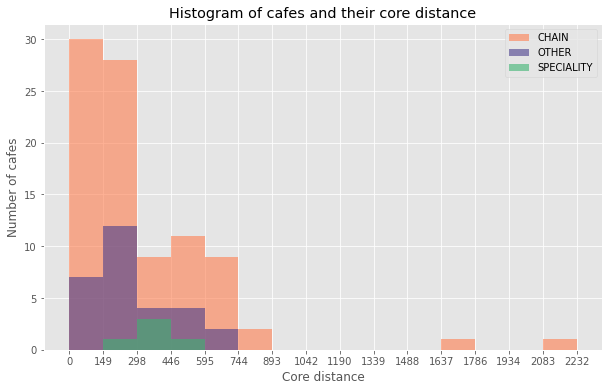

In [283]:
_, bin_edges = np.histogram(distances, 15)
distances[distances==0]=np.nan
distances.plot(kind='hist', 
                stacked=False, 
                figsize=(10, 6),
                xticks=bin_edges,
                bins=bin_edges,
                alpha=0.6,
                color=['coral', 'darkslateblue', 'mediumseagreen']
                )
plt.title('Histogram of cafes and their core distance')
plt.ylabel('Number of cafes')
plt.xlabel('Core distance')
plt.show()

From this histogram we can highlight that:
* chains are present in high densities 
* other cafes are more common in ~150 to ~300m from other cafes
* speciality cafes are present on the edges when both `other` and `chains` has relative low presence

## Results
We can define the functions we have used before so we can call them for different cities and analize the results

This function: `km_metrics` can helps define the `k` for K-Means

In [313]:
def km_metrics(city):
    cafes_in_city = scandinavian_cafes.loc[scandinavian_cafes['city']==city, ['lat', 'lng']].reset_index(drop=True)
    scaler = StandardScaler().fit(cafes_in_city)
    cafes_in_city = scaler.transform(cafes_in_city)
    distortions = []
    centers = []
    silhouettes = []
    for i in range(2, 11):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0
        )
        km.fit(cafes_in_city)
        centers.append(km.cluster_centers_)
        distortions.append(km.inertia_)
        predict = km.predict(cafes_in_city)
        silhouettes_avg = silhouette_score(cafes_in_city, predict)
        silhouettes.append(silhouettes_avg)

    # plot
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Distortion', color=color)
    ax1.plot(range(2,11), distortions, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Avg Silhouette', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(2,11), silhouettes, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(city)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(f'figures/km_metrics_{city}.png')
    plt.show()

Once we have `k` define we can use `cafes_per_cluster` to visualice each cluster

In [315]:
def cafes_per_cluster(city, k):
    cafes = scandinavian_cafes.loc[scandinavian_cafes['city']==city, ['name', 'lat', 'lng', 'type']]
    scaler = StandardScaler().fit(cafes[['lat', 'lng']])
    cafes_in_city = scaler.transform(cafes[['lat', 'lng']])
    km = KMeans(
            n_clusters=k, init='random',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0
        )
    km_labels = km.fit_predict(cafes_in_city)
    cafes['type_values'] = [e.name for e in cafes['type']]
    cafes_onehot = pd.get_dummies(cafes['type_values'])
    cafes_onehot['km_labels'] = km_labels
    cafes_group = cafes_onehot.groupby(['km_labels']).sum()
    cafes_group.plot(kind='bar', stacked=True)
    plt.title(city)
    plt.ylabel('Number of cafes')
    plt.xlabel('Cluster')
    plt.savefig(f'figures/km_{city}.png')
    plt.show()

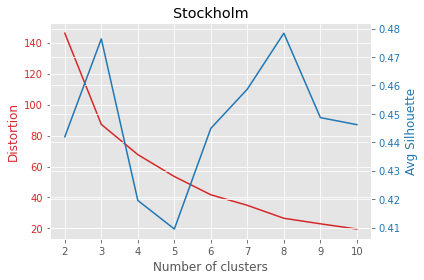

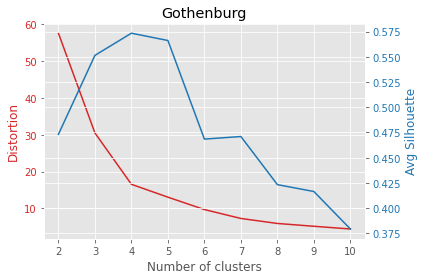

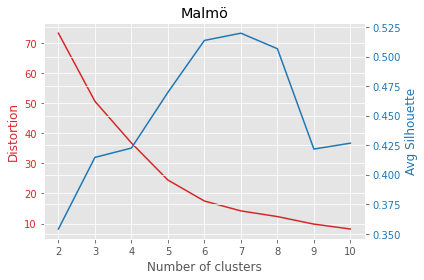

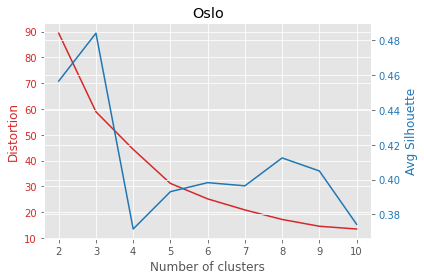

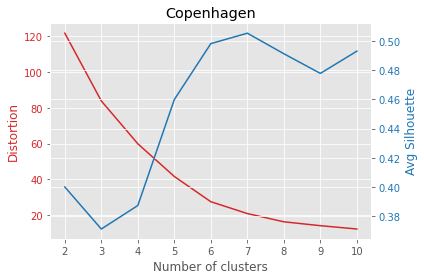

In [316]:
cities = ['Stockholm','Gothenburg', 'Malmö', 'Oslo', 'Copenhagen']
for city in cities:
    km_metrics(city)

We can define the `k` for each city now

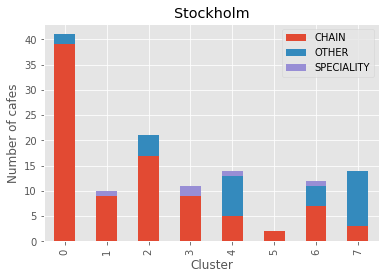

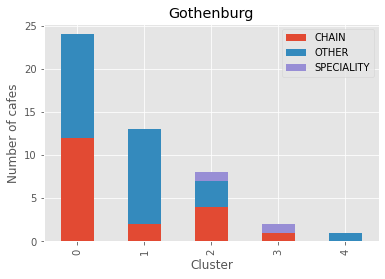

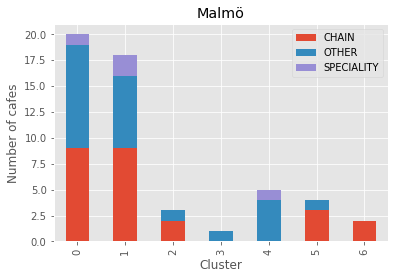

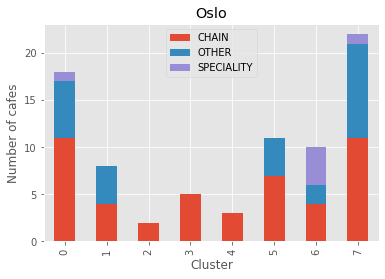

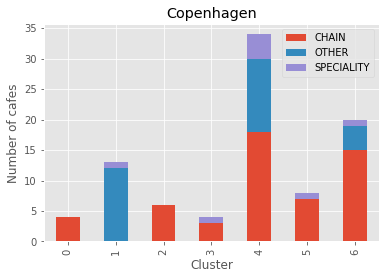

In [317]:
ks = [8 , 5, 7, 8, 7]
for city, k in zip(cities, ks):
    cafes_per_cluster(city, k)

### For OPTICS:

In [318]:
def cafes_dist(city):
    cafes = scandinavian_cafes.loc[scandinavian_cafes['city']==city, ['name', 'lat', 'lng', 'type']]
    op = OPTICS(cluster_method='xi', metric=lambda u,v: distance(u,v).m ).fit(cafes[['lat','lng']])
    cafes['op_label'] = op.labels_
    cafes['type_values'] = [e.name for e in cafes['type']]
    cafes['op_core_distance'] = op.core_distances_
    mean_dist = cafes.loc[:,['type_values', 'op_core_distance']].groupby(['type_values']).mean()
    print(city)
    cafes_onehot = pd.get_dummies(cafes['type_values'])
    distances = cafes_onehot.multiply(op.core_distances_, axis=0)
    labels = cafes_onehot.replace({0:np.nan}).multiply(op.labels_, axis=0)
    return mean_dist, distances, labels

In [319]:
list_distances = []
list_mean = []
list_labels = []
for city in cities:
    mean, dist, labels = cafes_dist(city)
    list_distances.append(dist)
    list_mean.append(mean)
    list_labels.append(labels)

Stockholm
Gothenburg
Malmö
Oslo
Copenhagen


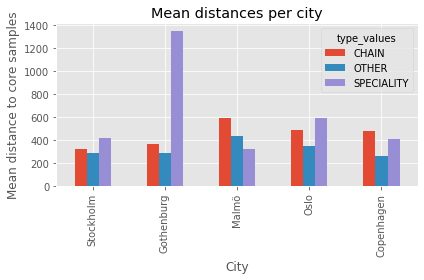

In [321]:
mean_distance = pd.concat(list_mean, axis=1)
mean_distance.columns = cities
mean_distance.transpose().plot(kind='bar')
plt.title('Mean distances per city')
plt.ylabel('Mean distance to core samples')
plt.xlabel('City')
plt.tight_layout()
plt.savefig('figures/op_mean_distances.png')
plt.show()

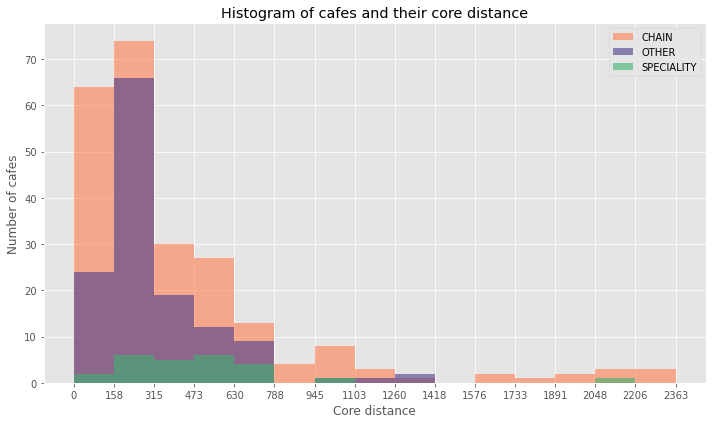

In [322]:
distances = pd.concat(list_distances) 
_, bin_edges = np.histogram(distances, 15)
distances[distances==0]=np.nan
distances.plot(kind='hist', 
                stacked=False, 
                figsize=(10, 6),
                xticks=bin_edges,
                bins=bin_edges,
                alpha=0.6,
                color=['coral', 'darkslateblue', 'mediumseagreen']
                )
plt.title('Histogram of cafes and their core distance')
plt.ylabel('Number of cafes')
plt.xlabel('Core distance')
plt.tight_layout()
plt.savefig('figures/op_distances_histogram.png')
plt.show()

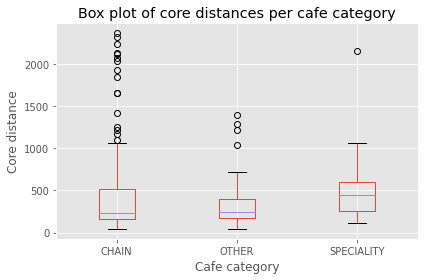

In [323]:
distances.plot(kind='box')
plt.title('Box plot of core distances per cafe category')
plt.ylabel('Core distance')
plt.xlabel('Cafe category')
plt.tight_layout()
plt.savefig('figures/op_distances_box.png')
plt.show()

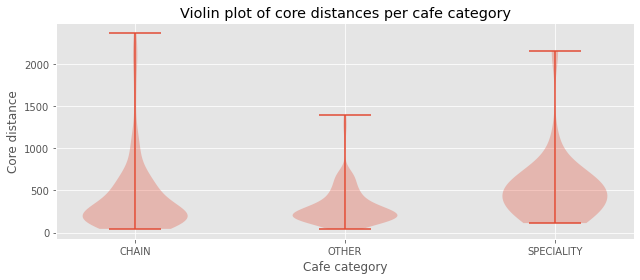

In [324]:
from math import isnan
distances_matrix = [[i for i in row if not isnan(i)] for row in distances.transpose().to_numpy().tolist()]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
ax.violinplot(distances_matrix)
ax.set_title('Violin plot of core distances per cafe category')
ax.set_ylabel('Core distance')
ax.set_xlabel('Cafe category')
ax.set_xticks([1,2,3])
ax.set_xticklabels(distances.columns.values.tolist())
plt.tight_layout()
plt.savefig('figures/op_distances_violin.png')
plt.show()

In [294]:
distances.describe()

,CHAIN,OTHER,SPECIALITY
count,235.000000,134.000000,25.000000
mean,421.699994,318.896797,515.870274
std,444.343202,229.374135,405.994959
min,44.467478,42.600131,112.631857
25%,155.331694,172.903517,255.602859
50%,233.823012,244.979202,443.330628
75%,519.591116,395.650190,595.208744
max,2363.353668,1394.030049,2152.650723


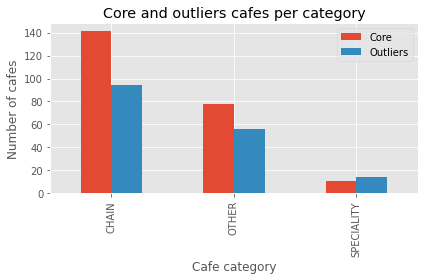

In [325]:
labels = pd.concat(list_labels) 
labels_sumary = pd.DataFrame()
# labels_sumary['Total'] = labels.count()
labels_sumary['Core'] = labels[labels>-1].count()
labels_sumary['Outliers'] = labels[labels==-1].count()
# labels_sumary['Proportion'] = labels[labels>-1].count() - labels[labels==-1].count()
labels_sumary.plot(kind='bar')
plt.title('Core and outliers cafes per category')
plt.ylabel('Number of cafes')
plt.xlabel('Cafe category')
plt.tight_layout()
plt.savefig('figures/op_core_outliers.png')
plt.show()

## Conclusion

Even though all the stores analyzed in this report belong to the same category of coffeehouses we can see a difference among this three categories just by inspecting their geographical location.
I would like to highlight the following points:

 1. Using K-Means we can see that not all the cluster have equals proportions of each kind of coffeehouse. In fact most of the clusters have a dominant kind kind of cafe. 

 2. Coffeehouses chains tends to create dense clusters. This kind of cafe can be very close one to another. Especially around areas like train stations or cities main avenues. 

 3. Traditional cafes locates for the most part between 160 and 315 meters from other cafes. This makes them part of the cafes cluster for the most part

 4. Specialty cafes are in general outliers and they locate outside the cafes clusters.  


A barista friend who has been in the profession for more than 10 years explained me the reason why cafes of the same owner (like chains) will locate close to each other. The rationale is management and shared resources. The manager of cafe can run two places if they are close by and in case of need one cafe can provide with supplies (coffee, cups, filters) to the other. By sharing baristas across the different locations a manager can make sure that the chain has a consistent quality. 

To close this report I would like to highlight:
* The amount of information that is freely available from amazing websites like European Coffee Trip.
* Even with an small piece of data like the geographical location and the store name we can infer very interesting results.
* Having access to someone with knowledge on the field can help us understand the causes of the results, confirming and/or questioning them.